In [3]:
# Cell 1：环境准备
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 如果你的 JSON 文件名称不是固定的，可以在这里改
DATA_PATH = "/home/fanghaotian/src/GRec/data/Instruments"  # 数据目录
DATASET = "Instruments"  # 数据集前缀，例如 example.inter.json

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

In [4]:
# Cell 2：读取交互序列
file_path = os.path.join(DATA_PATH, f"{DATASET}.inter.json")
with open(file_path) as f:
    inters = json.load(f)

# 转成 list 并按 key 排序，保证顺序一致
seqs = [inters[k] for k in sorted(inters.keys(), key=lambda x: int(x))]

In [5]:
# Cell 3：统计序列长度
lengths = [len(seq) for seq in seqs]
print("总序列数:", len(lengths))
print("长度示例（前 10 个）:", lengths[:10])

总序列数: 17112
长度示例（前 10 个）: [8, 6, 5, 5, 17, 34, 7, 6, 11, 6]


In [12]:
sorted_length = sorted(lengths)
sorted_length[-30:]

[47,
 48,
 48,
 49,
 51,
 52,
 52,
 53,
 54,
 54,
 55,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 67,
 67,
 67,
 70,
 71,
 78,
 81,
 88,
 110,
 112,
 113,
 131]

In [24]:
# only save the length 10% to 90%
min_len = sorted_length[int(len(sorted_length) * 0.001)]
max_len = sorted_length[int(len(sorted_length) * 0.999)]
lengths = [l for l in sorted_length if l >= min_len and l <= max_len]

min_len, max_len, len(lengths)

(5, 58, 17095)

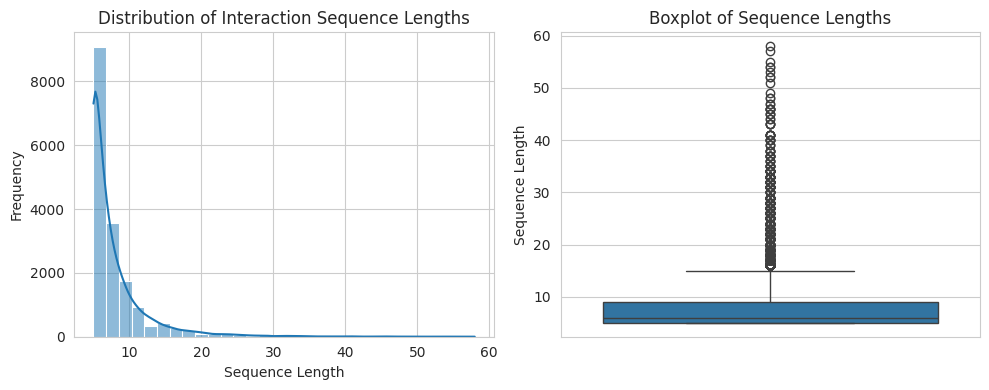

In [25]:
# Cell 4: Plot distribution
plt.subplot(1, 2, 1)
sns.histplot(lengths, bins=30, kde=True)
plt.title("Distribution of Interaction Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(y=lengths)
plt.title("Boxplot of Sequence Lengths")
plt.ylabel("Sequence Length")

plt.tight_layout()
plt.show()

In [7]:
# Cell 5（可选）：打印一些统计量
import pandas as pd

pd.Series(lengths).describe()

count    17112.000000
mean         7.960846
std          5.141910
min          5.000000
25%          5.000000
50%          6.000000
75%          9.000000
max        131.000000
dtype: float64

In [ ]:
import torch
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from qwen_vl_utils import process_vision_info

torch.cuda.set_device(5)

# 1. 加载模型（默认 float16，省显存）
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype=torch.float16, device_map=device
)

# 2. 本地图片列表（按需增删）
img_paths = [
    "/home/fanghaotian/src/GRec/data/Instruments/images/0739079891.jpg",
    "/home/fanghaotian/src/GRec/data/Instruments/images/0786615206.jpg",
    "/home/fanghaotian/src/GRec/data/Instruments/images/1480360295.jpg",
    "/home/fanghaotian/src/GRec/data/Instruments/images/9792372326.jpg",
]

# 3. 统一的文本 prompt
base_prompt = "Describe this image in English."


def print_gpu_mem(msg: str):
    if device == "cuda":
        # 已分配显存（MB）
        allocated = torch.cuda.memory_allocated() / 1024**2
        # 保留显存（MB）
        reserved = torch.cuda.memory_reserved() / 1024**2
        print(
            f"{msg} | allocated={allocated:.1f} MB, reserved={reserved:.1f} MB"
        )
    else:
        print(f"{msg} | running on CPU")


# 4. 依次测试 1~4 张图
for k in range(1, len(img_paths) + 1):
    images = img_paths[:k]
    print("=" * 50)
    print(f"Testing with {k} image(s): {images}")
    print_gpu_mem("Before build inputs")

    # 构造对话格式（OpenAI-style）
    messages = []
    content = [{"type": "image", "image": p} for p in images]
    content.append({"type": "text", "text": base_prompt})
    messages.append({"role": "user", "content": content})

    # 预处理
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to(device)

    print_gpu_mem("After build inputs / Before forward")

    # 前向（不生成，只跑 encoder+decoder 一步）
    with torch.no_grad():
        outputs = model(**inputs)

    print_gpu_mem("After forward")

    # 可选：清空缓存，防止 PyTorch 缓存策略影响下一次观测
    if device == "cuda":
        torch.cuda.empty_cache()

print("Done.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Testing with 1 image(s): ['/home/fanghaotian/src/GRec/data/Instruments/images/0739079891.jpg']
Before build inputs | allocated=4213.3 MB, reserved=4716.0 MB
After build inputs / Before forward | allocated=4219.1 MB, reserved=4716.0 MB
After forward | allocated=4362.5 MB, reserved=4720.0 MB
Testing with 2 image(s): ['/home/fanghaotian/src/GRec/data/Instruments/images/0739079891.jpg', '/home/fanghaotian/src/GRec/data/Instruments/images/0786615206.jpg']
Before build inputs | allocated=4362.5 MB, reserved=4720.0 MB
After build inputs / Before forward | allocated=4366.7 MB, reserved=4720.0 MB
After forward | allocated=4441.5 MB, reserved=4740.0 MB
Testing with 3 image(s): ['/home/fanghaotian/src/GRec/data/Instruments/images/0739079891.jpg', '/home/fanghaotian/src/GRec/data/Instruments/images/0786615206.jpg', '/home/fanghaotian/src/GRec/data/Instruments/images/1480360295.jpg']
Before build inputs | allocated=4441.5 MB, reserved=4738.0 MB
After build inputs / Before forward | allocated=4447.0

: 

一张图片大概 100 MB